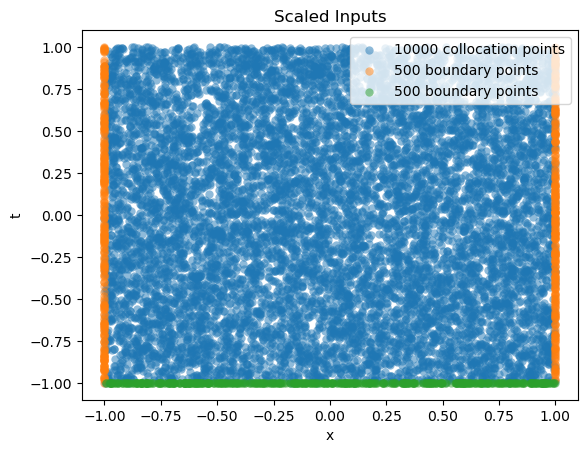

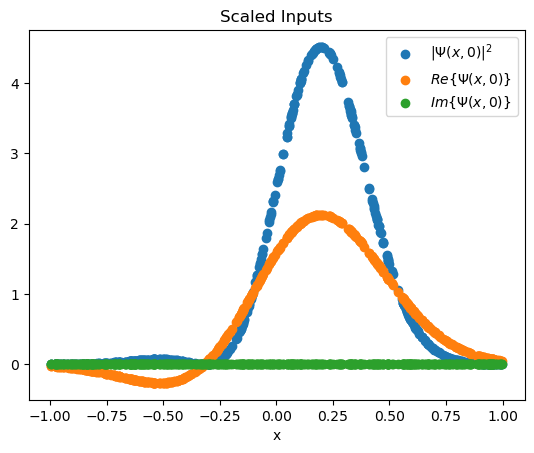

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2) * x * tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
# scaled interior points
x_f = scale_inputs(x_f, x_min, x_max)
t_f = scale_inputs(t_f, t_min, t_max)

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
# scaled boundary points
x_b = scale_inputs(x_b, x_min, x_max)
t_b = scale_inputs(t_b, t_min, t_max)

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)
# scaled initial points
x_i = scale_inputs(x_i, x_min, x_max)
t_i = scale_inputs(t_i, t_min, t_max)
# normalized psi_i
norm = tf.math.sqrt(tf.reduce_mean(tf.math.abs(psi_i)**2))
psi_i_Re = tf.math.real(psi_i) / norm
psi_i_Im = tf.math.imag(psi_i) / norm

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} boundary points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

# plotting initial condition
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'$|\Psi(x,0)|^2$')
plt.scatter(x_i, psi_i_Re, label=r'$Re\{\Psi(x,0)\}$')
plt.scatter(x_i, psi_i_Im, label=r'$Im\{\Psi(x,0)\}$')
plt.xlabel('x')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

In [22]:
# define Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=256, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=256, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, omega):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t], axis=1)
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x)
        v_x = tape1.gradient(v, x)
        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    del tape1, tape2

    potential = 0.5 * omega**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def loss_fn(model, interior, boundary, initial, w):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    omega = w

    f_u, f_v = pde_residual(model, x_f, t_f, omega)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v))

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b))

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i)))
    
    return loss_f + loss_b + loss_i, (loss_f, loss_b, loss_i)

# Create the model
model = PINN(input_dim=2, mapping_size=256, scale=10.0)

# Save the model in Keras format
model_save_path = "Schrodinger_equation_v3.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Load the model
loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'PINN': PINN})

# Dummy input to build the model (batch size 1, input_dim = 2)
dummy_input = tf.concat([x_f[:5], t_f[:5]], axis=1)
_ = loaded_model(dummy_input)

loaded_model.summary()

Model saved to Schrodinger_equation_v3.keras


Model: "pinn_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_15        │ ?                      │           512 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (5, 256)               │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (5, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (5, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (5, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (5, 2)                 │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,730 (2.52 MB)

 Trainable params: 329,218 (2.51 MB)

 Non-trainable params: 512 (4.00 KB)

In [23]:
#############################################################################

# Instantiate the Model
pinn = PINN()

# Define the Optimizer
# Learning rate schedule with exponential decay
initial_learning_rate = 0.001
decay_rate = 0.9
decay_steps = 2000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# ADAM optimizer with beta1 = 0.09, beta2 = 0.999 (unusual but from paper)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), omega)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li)

In [ ]:
#############################################################################

# List to store the loss values
loss_history = []
epoch_history = [0,]

# Define the loss threshold
loss_threshold = 1e-3

# Early stopping
early_stopping_patience = 500
best_loss = float('inf')
patience_counter = 0

# Start the timer
start_time = time.time()

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li) = train_step(pinn, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega)
    loss_value = loss.numpy()
    loss_history.append(loss_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.5e} (f = {lf:.5e}, b = {lb:.5e}, i = {li:.5e})")
        
        # Save the model in Keras format
        model_save_path_0 = "interrupted_Schrodinger_equation_v3.keras"
        pinn.save(model_save_path_0)
        print(f"Model saved to {model_save_path_0}")
        
    if loss_value < best_loss:
        best_loss = loss_value
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss_value}")
        break
    
    if loss_value < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss_value}")
        break
    
    epoch += 1
    epoch_history.append(epoch)

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(epoch_history, loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model in Keras format
model_save_path = "Schrodinger_equation_v3.keras"
pinn.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(model_save_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

# Check prediction consistency
x_test = np.linspace(x_min, x_max, 100).reshape(-1,1).astype(np.float64)
t_test = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float64)

x_test_tensor = tf.convert_to_tensor(x_test)
t_test_tensor = tf.convert_to_tensor(t_test)

original_prediction = pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
    print("Predictions do not match after loading!")
else:
    print("Predictions match.")